In [574]:
import numpy as np

In [575]:
import matplotlib.pyplot as plt

In [576]:
#paramtros de caída libre
g, k = 9.81, 0.5
y0, v0 = 10, 100
z0 = np.array([y0, v0])

In [577]:
#paramtros de resorte
x0_1=0.7
y0_1=0
x0_2=-0.7
y0_2=0

v0x_1=0
v0y_1=0.1
v0x_2=0
v0y_2=-0.1
w = 0.16
l0 = 1

u0 = np.array([x0_1,v0x_1,y0_1,v0y_1,x0_2,v0x_2,y0_2,v0y_2])


In [578]:
tstop = 100
h = 1/10
t=np.arange(0.,tstop+h,h)

In [579]:
def caidaLibre(z, t ,g, k): 
    derivs = np.array([z[1],  -k*z[1] -g ])
    return derivs

In [580]:
def resorte(u,t,w,l0):
    #l es la longitud del resorte en un t
    l=np.sqrt((u[4]-u[0])**2+(u[6]-u[2])**2)
    deriv = np.array([u[1],(w**2)*(l-l0)*(u[4]-u[0]),u[3],(w**2)*(l-l0)*(u[6]-u[2]),u[5],-(w**2)*(l-l0)*(u[4]-u[0]),u[7],-(w**2)*(l-l0)*(u[6]-u[2])])
    #deriv = np.array([u[1],(w**2)*(l-l0)*(u[4]-u[0])/l,u[3],(w**2)*(l-l0)*(u[6]-u[2])/l,u[5],-(w**2)*(l-l0)*(u[4]-u[0])/l,u[7],-(w**2)*(l-l0)*(u[6]-u[2])/l])
    return deriv

In [581]:
def MedioModificado(f_user, U0, t, *args):
    # aquí el método de punto medio nos da el resultado final a un dt anterior del fin
    # del intervalo. Similar a los otros métodos estudiados
    n = t.size
    neq = U0.size
    u = np.zeros((n, neq))

    u[0] = U0
    dt = t[1]-t[0]
    
    sol1 = u[0] + 0.5*dt*f_user(U0,t[0],*args)
    u[1] = u[0] + dt*f_user(sol1,t[0]+0.5*dt,*args)    
    
    for i in range(1,n-1):
        sol1 = sol1 + dt*f_user(u[i],t[i],*args)
        u[i+1] = u[i] + dt*f_user(sol1,t[i]+0.5*dt,*args)
        
    u[n-1] = 0.5*(u[n-1]+sol1+0.5*dt*f_user(u[n-1],t[n-1],*args))
    return u

In [582]:
def BulirschStoer(f_user, z0, a, b, tol, *args):
    #Las filas de los resultados R lo almacenamos en dos arreglos Rprev y R
    #Calculo de R_1,1. Medio Modificado pero donde sale el último punto del intervalo.
    H = b-a
    tol = H*tol
    n = 1
    t = np.array([a,b])
    dimz = z0.size
    z = MedioModificado(f_user, z0, t, *args)
    Rprev = np.zeros((1,dimz))
    Rprev[0]=z[-1]
    while True:
        n += 1
        # h = H/n
        t= np.linspace(a,b,n+1)
        z = MedioModificado(f_user, z0, t, *args)
        R = np.zeros((n,dimz))
        R[0]=z[-1]
        for l in range(1,n):
            epsilon = (R[l-1]-Rprev[l-1])/((n/(n-1))**(2*l)-1)
            R[l] = R[l-1] + epsilon
        #Como definimos el error: solamente las posiciones
        error = np.sqrt((np.take(epsilon,range(0,dimz,2))**2).sum())
        if error <= tol:
            break
        else:
            Rprev = np.copy(R)
    return R[n-1]            

In [583]:
def BSmultiple(f_user,U0,t,tol,*args):
    nt = t.size
    dimU=U0.size
    u=np.zeros((nt,dimU))
    u[0]=U0
    H=t[1]-t[0]
    j=0
    for j,t in enumerate(t[:nt-1]):
        U0=u[j]
        u[j+1]=BulirschStoer(f_user,U0,t,t+H,tol,*args)
    return u

In [584]:
solPMM=MedioModificado(caidaLibre,z0,t,g,k)
solBSM=BSmultiple(caidaLibre,z0,t,0.001,g,k )


In [585]:
resPMM=MedioModificado(resorte,u0,t,w,l0)
resBSM=BSmultiple(resorte,u0,t,0.001,w,l0)

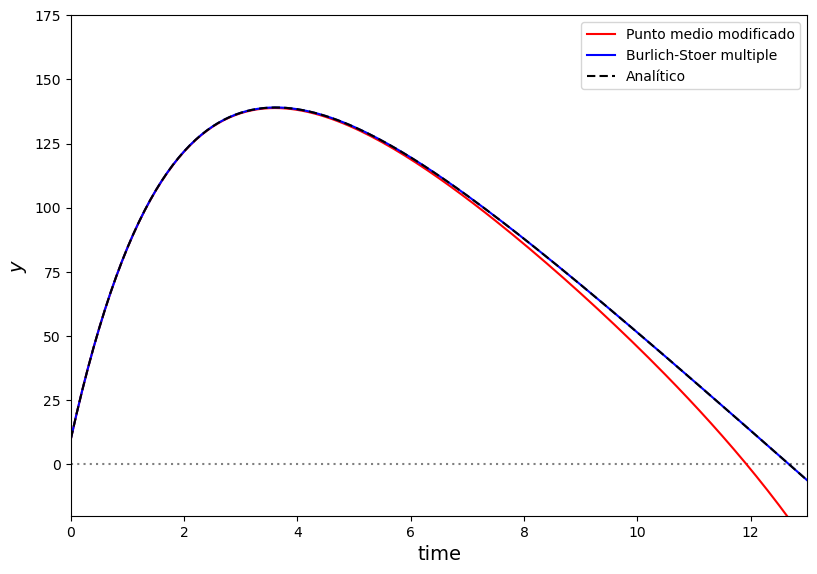

In [586]:
plt.figure(figsize=(9.5,6.5))
plt.plot(t,solPMM[:,0],color = 'red',label = 'Punto medio modificado')
plt.plot(t,solBSM[:,0],color = 'blue',label = 'Burlich-Stoer multiple')
y = y0 - (g/k)*t +(g+k*v0)*(1-np.exp(-k*t))/k**2.
plt.plot(t, y, dashes=(4, 2), color='black',label = "Analítico")
plt.xlabel('time', fontsize=14)
plt.ylabel(r'$y$', fontsize=14)
plt.xlim(0.,13)
plt.ylim(-20,175)
plt.axhline(color='gray',dashes=(1, 2),zorder=-1)
plt.legend(loc = 'best')
plt.show()

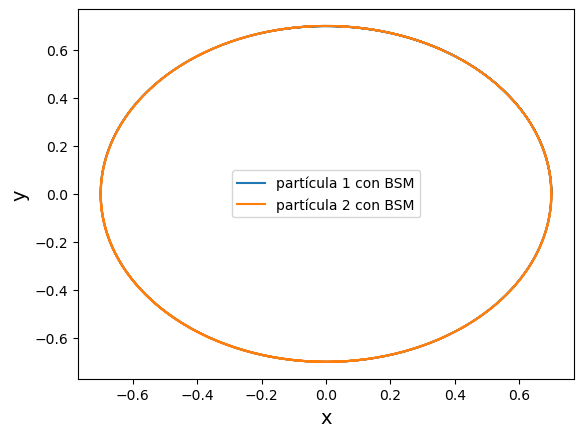

In [587]:
#plt.plot(resPMM[:,0],resPMM[:,2], label = "partícula 1 con PMM")
plt.plot(resBSM[:,0],resBSM[:,2], label = "partícula 1 con BSM")
plt.plot(resBSM[:,4],resBSM[:,6], label = "partícula 2 con BSM")
plt.xlabel('x',fontsize=14)
plt.ylabel('y', fontsize=14)
plt.legend(loc = 'best')
plt.show()

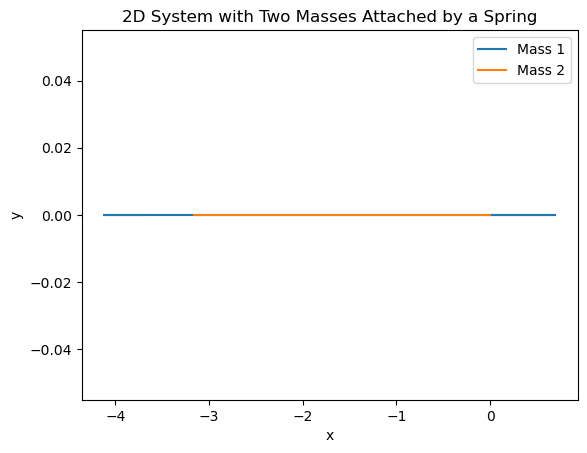

In [588]:
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
m1 = 1
m2 = 2
k = 1

# Define differential equations
def spring_system(state, t):
    x1, y1, x2, y2, v1x, v1y, v2x, v2y = state
    dx1dt = v1x
    dy1dt = v1y
    dx2dt = v2x
    dy2dt = v2y
    dv1xdt = (-k/m1) * (x1 - x2)
    dv1ydt = (-k/m1) * (y1 - y2)
    dv2xdt = (-k/m2) * (x2 - x1)
    dv2ydt = (-k/m2) * (y2 - y1)
    return [dx1dt, dy1dt, dx2dt, dy2dt, dv1xdt, dv1ydt, dv2xdt, dv2ydt]

# Set up initial conditions
#init_state = [0, 0.7, 0, -0.7, 0.1, 0, -0.1, 0]
init_state = [0.0, 00, 0.0, 0, 1.0, 0.0, -1.0, 0.0]

# Set up time array
t_arr = np.linspace(0, 10, 1000)

# Solve differential equations using odeint
from scipy.integrate import odeint
sol = odeint(spring_system, init_state, t_arr)

# Extract positions of masses from solution
x1_arr = sol[:, 0]
y1_arr = sol[:, 1]
x2_arr = sol[:, 2]
y2_arr = sol[:, 3]

# Plot positions of masses
plt.plot(x1_arr, y1_arr, label='Mass 1')
plt.plot(x2_arr, y2_arr, label='Mass 2')
plt.xlabel('x')
plt.ylabel('y')
plt.title('2D System with Two Masses Attached by a Spring')
plt.legend()
plt.show()
